In [76]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense

import numpy as np
import cv2
from PIL import ImageFile
import wandb
from wandb.keras import WandbCallback
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
wandb.init(project="Animals_Classification")

In [2]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

### Dataset

In [5]:
dataset_path = "animals"
width = height = 224

idg = ImageDataGenerator(
    rescale = 1./255,

    # Augmentation
    horizontal_flip = True,
    zoom_range = 0.1,
    rotation_range = 10,
    brightness_range = (0.9, 1.1),
    validation_split = 0.2
)

train_data = idg.flow_from_directory(
    dataset_path,
    target_size = (width, height),
    class_mode = "categorical",
    subset = "training"
)

val_data = idg.flow_from_directory(
    dataset_path,
    target_size = (width, height),
    class_mode = "categorical",
    subset = "validation"
)

Found 763 images belonging to 4 classes.
Found 188 images belonging to 4 classes.


### Model

In [6]:
model = tf.keras.models.Sequential([
      Conv2D(32, (3, 3), activation="relu", input_shape=(width, height, 3)),
      Conv2D(32, (3, 3), activation="relu"),
      MaxPool2D(),
      Conv2D(32, (3, 3), activation="relu"),
      Conv2D(32, (3, 3), activation="relu"),
      MaxPool2D(),
      Conv2D(64, (3, 3), activation="relu"),
      Conv2D(64, (3, 3), activation="relu"),
      MaxPool2D(),

      Flatten(),
      Dense(256, activation="relu"),
      Dense(512, activation="relu"),
      Dense(1024, activation="relu"),
      Dense(4, activation="softmax")
])

In [7]:
config = wandb.config
config.learning_rate = 0.0001

In [8]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=config.learning_rate),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=["accuracy"])

In [11]:
model.fit(train_data, validation_data=val_data, epochs=2, callbacks=[WandbCallback()])

Epoch 1/2
24/24 [==============================] - 37s 2s/step - loss: 0.6395 - accuracy: 0.7523 - val_loss: 0.9031 - val_accuracy: 0.6649
Epoch 2/2
24/24 [==============================] - 36s 1s/step - loss: 0.5458 - accuracy: 0.7955 - val_loss: 0.9695 - val_accuracy: 0.6436


### save model

In [ ]:
model.save("model/animalsClassification.h5")

### load model

In [62]:
model = tf.keras.models.load_model("model/animalsClassification.h5")

### test

In [63]:
width = height = 224
test_path = "test"

idg = ImageDataGenerator(
    rescale = 1./255
)

test_data = idg.flow_from_directory(
    test_path,
    target_size = (width, height),
    class_mode = "categorical"
)

Found 120 images belonging to 4 classes.


In [64]:
model.evaluate(test_data)

4/4 [==============================] - 2s 311ms/step - loss: 0.6731 - accuracy: 0.7583


[0.6731169819831848, 0.7583333253860474]

In [65]:
X_test, Y_test = test_data.next()

In [66]:
Y_test = np.argmax(Y_test, axis=1)
Y_test

array([3, 3, 1, 1, 0, 1, 1, 3, 1, 2, 2, 2, 3, 3, 1, 2, 3, 2, 0, 3, 2, 0,
       1, 3, 2, 0, 0, 2, 0, 3, 2, 0], dtype=int64)

In [67]:
Y_pred = np.argmax(model.predict(X_test), axis=1)
Y_pred

array([3, 3, 1, 1, 2, 1, 1, 3, 1, 2, 0, 2, 3, 0, 1, 2, 3, 2, 0, 3, 2, 0,
       1, 3, 2, 0, 0, 1, 2, 1, 2, 0], dtype=int64)

### Confusion Matrix

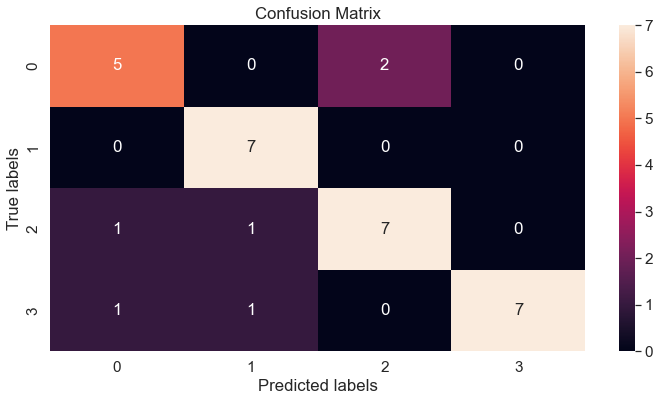

In [68]:
con_matrix = confusion_matrix(Y_test, Y_pred)

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
sns.heatmap(con_matrix, annot=True, fmt='g', ax=ax)
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
plt.show()

### inference

In [81]:
def inference(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (width, height))
    img = img / 255
    img = img.reshape(1, width, height, 3) # 3d ---> 4d
    return img

In [83]:
elephant_img = inference("test/elephant/4cf93fb44aa3844d4d34fc66d0278075.jpg") # 0
result = np.argmax(model.predict(elephant_img))
result

0

In [87]:
koala_img = inference("test/koala/3fbf44ac60f36d592babd8c1633b3b51.jpg") # 1
result = np.argmax(model.predict(koala_img))
result

1

In [88]:
lion_img = inference("test/lion/5a2e6c09f3e692bf0729e44ef13ed1e1.jpg") # 2
result = np.argmax(model.predict(lion_img))
result

2

In [89]:
wolf_img = inference("test/wolf/3d76df2a3b615a2b328aeffda30d01d9.jpg") # 3
result = np.argmax(model.predict(wolf_img))
result

3